In [1]:
using Revise
includet("../scripts/ma_comp_v3.jl")

In [2]:
using GLMakie
using CairoMakie
using JLD2
using GraphvizDotLang: attr
using GraphvizDotLang

# Working with one compgraph

In [3]:
L = 3
# codes = rand(0:255, 20)
codes = filter(c->c!=204, collect(0:255));

cg = make_merged_ssac_compgraph(L, codes;
    transprob_threshold=0.999,
    merge_shifted=true,
    # include_self_edges=false
);

┌ Warning: Note: adding edges with a zero weight to this graph type has no effect.
└ @ SimpleWeightedGraphs ~/.julia/packages/SimpleWeightedGraphs/Ab8wv/src/simpleweighteddigraph.jl:170


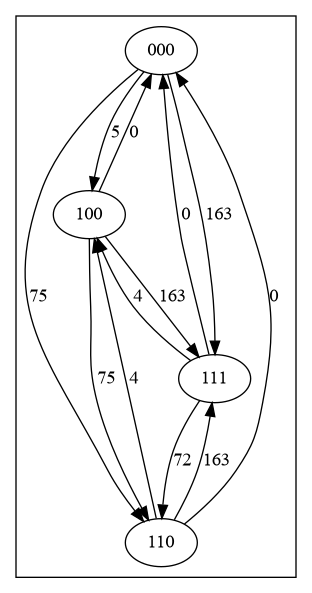

In [5]:
g = gv_compgraph(cg;
    # elabel=:all,
    # cluster_by=:numones,
    cluster_by=:sccs,
    # show_cond=false,
    # skip_self_edges=false
) |> attr(:graph; layout="dot", rankdir="TB")

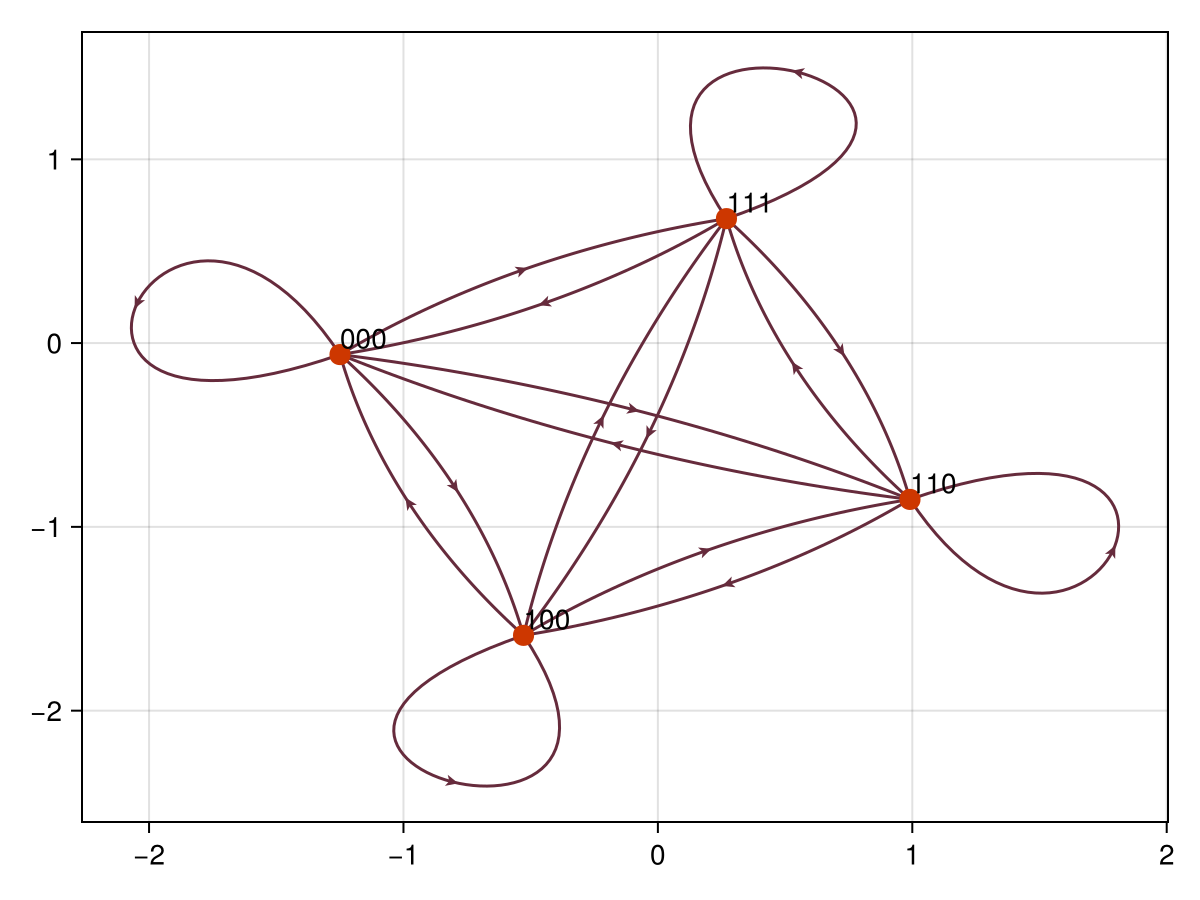

In [6]:
f = plot_compgraph(cg;
    layout=Spring(dim=2)
)
# display(GLMakie.Screen(), f)
f

### Commutavity v2

In [657]:
cdf = find_noncommutative(cg);
nrow(cdf)

169744

In [750]:
# find those which always change, never diffuse away and arrive at different results
xx = @subset(cdf,
    # require non-commutativity
    :s12 .!= :s21,
    # require no diffusing away
    :s12 .!= nothing,
    :s21 .!= nothing,
    # make sure every rule moves the state
    # :s1 .!= :src,
    # :s2 .!= :src,
    # :s12 .!= :s1,
    # :s21 .!= :s2,
    # also filter those that make the switching triangle
    # (:s1 .!= :s21) .|| (:s2 .!= :s12),
    # filter switching or part open triangles
    # (:s1 .!= :s21),
    # (:s2 .!= :s12),
    # also get rid of those arriving at all 0s and all 1s
    :s12 .!= "000",
    :s12 .!= "111",
    :s21 .!= "000",
    :s21 .!= "111",
    # or otherwise involving all 0s or all 1s
    :s1 .!= "000",
    :s1 .!= "111",
    :s2 .!= "000",
    :s2 .!= "111",
    :src .!= "000",
    :src .!= "111",
);
@show nrow(xx)
rand(eachrow(xx))

nrow(xx) = 1296


Row,r1,r2,src,code,s1,s2,s12,s21
,Int64,Int64,String,Int64,Union…,Union…,Union…,Union…
875,141,92,100,3,100,110,110,100


In [751]:
display(cacode_to_Ks(4))
display(cacode_to_Ks(78))

([0 0; 0 0], [0 1; 1 1])

([0 1; 0 0], [0 0; 0 1])

In [752]:
# only get one pair of rules per "pathway"
pathvars = [:src, :s1, :s2, :s12, :s21]
gd = groupby(xx, pathvars)
xx = combine(gd, ((:r1, :r2) .=> first)...)

Row,src,s1,s2,s12,s21,r1_first,r2_first
,String,Union…,Union…,Union…,Union…,Int64,Int64
1,100,100,110,110,100,4,75
2,110,100,110,110,100,4,75
3,100,110,100,100,110,75,4
4,110,110,100,100,110,75,4


### Commutavity v1

In [577]:
cdf, crs = test_commutative(cg)

countmap(cdf.code)

Dict{Int64, Int64} with 4 entries:
  4 => 62234
  2 => 29892
  3 => 24872
  1 => 52746

In [578]:
noncom = cdf[cdf.code .== 3,:];
@show nrow(noncom)
rand(eachrow(noncom))

nrow(noncom) = 24872


Row,r1,r2,st1,code,f12,f21,final_state
,Int64,Int64,String,Int64,Union…,Union…,Union…
1359,10,223,111,3,110,000,


In [580]:
xx = @subset(noncom,
    :st1 .!= "000",
    :st1 .!= "111",
    :f12 .!= "000",
    :f12 .!= "111",
    :f21 .!= "000",
    :f21 .!= "111",
)
@show nrow(xx)
rand(eachrow(xx))

nrow(xx) = 1296


Row,r1,r2,st1,code,f12,f21,final_state
,Int64,Int64,String,Int64,Union…,Union…,Union…
259,45,89,100,3,110,100,


In [571]:
display(cacode_to_Ks(216))
display(cacode_to_Ks(4))

([0 0; 1 0], [1 0; 0 0])

([0 0; 0 0], [0 1; 1 1])

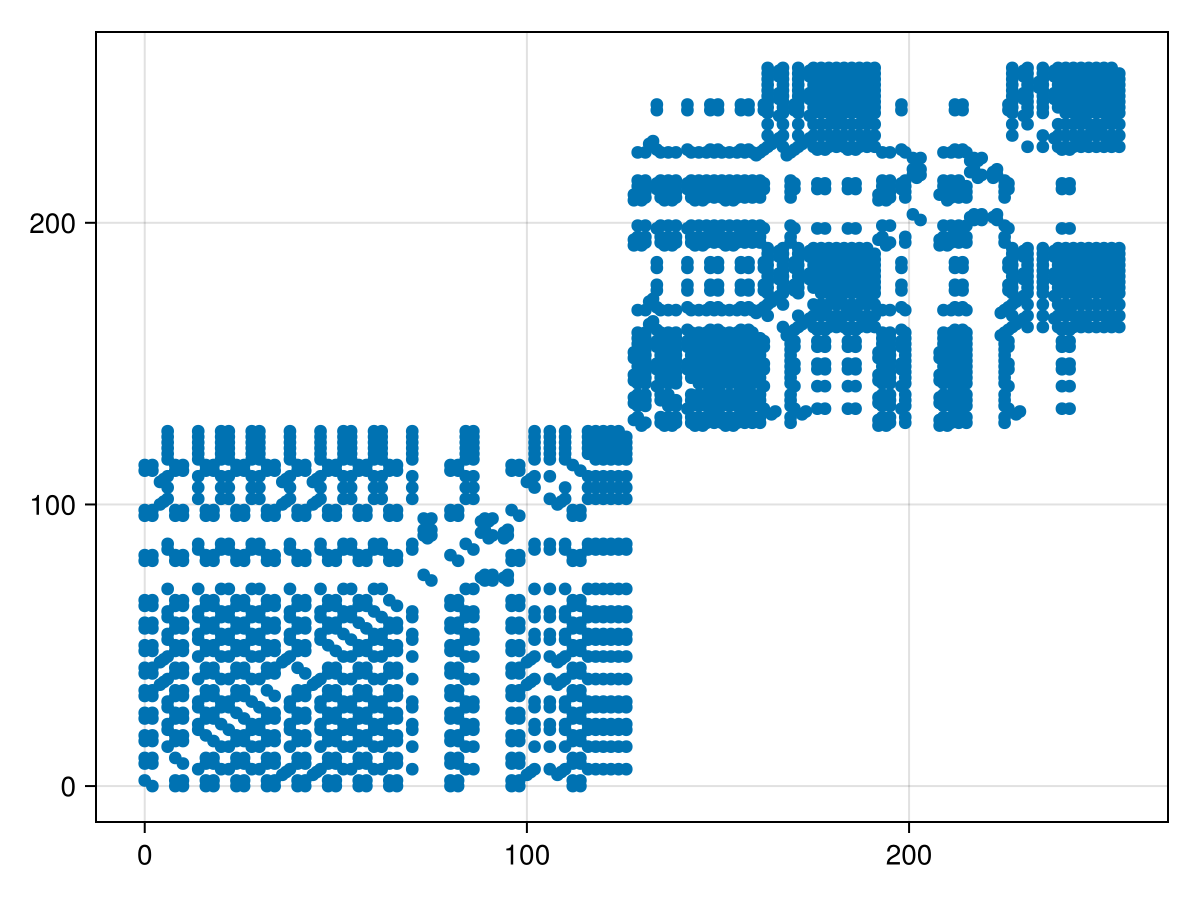

In [564]:
xx = crs[crs.alwayscommutative .&& crs.dosomething,:]
# xx = crs[crs.alwayscommutative,:]
xx = xx[xx.r1 .!= xx.r2,:]
f = scatter(xx.r1, xx.r2)
# display(GLMakie.Screen(), f)
f

In [562]:
xx = cdf[(cdf.code .== 4) .&& (cdf.st1 .!= cdf.final_state),:]

Row,r1,r2,st1,code,f12,f21,final_state
,Int64,Int64,String,Int64,Union…,Union…,Union…
1,0,0,001,4,000,000,000
2,0,0,010,4,000,000,000
3,0,0,011,4,000,000,000
4,0,0,100,4,000,000,000
5,0,0,101,4,000,000,000
6,0,0,110,4,000,000,000
7,0,0,111,4,000,000,000
8,0,2,001,4,000,000,000
9,0,2,010,4,000,000,000


### Playing around some more

In [279]:
rgs = find_rule_groups(cg)
present_rules = sort(unique(reduce(vcat, rgs)))
for r1 in present_rules
    for r2 in present_rules
        for rg in rgs
            x1 = r1 in rg
            x2 = r2 in rg
            if x1 && x2
                @show rg
            end
        end
    end
end

rg = [0, 2, 8, 10, 16, 18, 24, 26, 32, 34, 40, 42, 48, 50, 56, 58, 64, 66, 80, 82, 96, 98, 112, 114]
rg = [0, 2, 8, 10, 16, 18, 24, 26, 32, 34, 40, 42, 48, 50, 56, 58, 64, 66, 80, 82, 96, 98, 112, 114, 128, 130, 136, 138, 144, 146, 152, 154, 192, 194, 208, 210]
rg = [0, 2, 8, 10, 16, 18, 24, 26, 32, 34, 40, 42, 48, 50, 56, 58, 64, 66, 72, 80, 82, 96, 98, 104, 112, 114, 128, 130, 136, 138, 144, 146, 152, 154, 160, 168, 192, 194, 200, 208, 210, 224, 232]
rg = [0, 2, 8, 10, 16, 18, 24, 26, 32, 34, 40, 42, 48, 50, 56, 58, 64, 66, 80, 82, 96, 98, 112, 114]
rg = [0, 2, 8, 10, 16, 18, 24, 26, 32, 34, 40, 42, 48, 50, 56, 58, 64, 66, 80, 82, 96, 98, 112, 114, 128, 130, 136, 138, 144, 146, 152, 154, 192, 194, 208, 210]
rg = [0, 2, 8, 10, 16, 18, 24, 26, 32, 34, 40, 42, 48, 50, 56, 58, 64, 66, 72, 80, 82, 96, 98, 104, 112, 114, 128, 130, 136, 138, 144, 146, 152, 154, 160, 168, 192, 194, 200, 208, 210, 224, 232]
rg = [0, 2, 8, 10, 16, 18, 24, 26, 32, 34, 40, 42, 48, 50, 56, 58, 64, 66, 80, 82, 96,

Excessive output truncated after 524450 bytes.

rg = [0, 2, 8, 10, 16, 18, 24, 26, 32, 34, 40, 42, 48, 50, 56, 58, 64, 66, 72, 80, 82, 96, 98, 104, 112, 114, 128, 130, 136, 138, 144, 146, 152, 154, 160, 168, 192, 194, 200, 208, 210, 224, 232]
rg = [0, 2, 8, 10, 16, 18, 24, 26, 32, 34, 40, 42, 48, 50, 56, 58, 64, 66, 80, 82, 96, 98, 112, 114, 128, 130, 136, 138, 144, 146, 152, 154, 192, 194, 208, 210]
rg = [0, 2, 8, 10, 16, 18, 24, 26, 32, 34, 40, 42, 48, 50, 56, 58, 64, 66, 72, 80, 82, 96, 98, 104, 112, 114, 128, 130, 136, 138, 144, 146, 152, 154, 160, 168, 192, 194, 200, 208, 210, 224, 232]
rg = [0, 2, 8, 10, 16, 18, 24, 26, 32, 34, 40, 42, 48, 50, 56, 58, 64, 66, 80, 82, 96, 98, 112, 114, 128, 130, 136, 138, 144, 146, 152, 154, 192, 194, 208, 210]
rg = [0, 2, 8, 10, 16, 18, 24, 26, 32, 34, 40, 42, 48, 50, 56, 58, 64, 66, 72, 80, 82, 96, 98, 104, 112, 114, 128, 130, 136, 138, 144, 146, 152, 154, 160, 168, 192, 194, 200, 208, 210, 224, 232]
rg = [0, 2, 8, 10, 16, 18, 24, 26, 32, 34, 40, 42, 48, 50, 56, 58, 64, 66, 80, 82, 96, 98, 11

# Making ma_red_compgraph plots

In [204]:
codes = filter(c->c!=204, collect(0:255)); # skip the no-enzyme rule
for L in 2:5
    @time rcg = make_merged_ssac_compgraph(L, codes;
        transprob_threshold=0.999,
        merge_shifted=true
    );

    ak = (;)
    if L > 9
        ak = (; ak..., filter_sccs=3)
    end
    @time gvplot = gv_compgraph_sccs(rcg;
        elabel=:first,
        ak...
    ) |> attr(:graph; layout="dot", rankdir="TB")

    GraphvizDotLang.save(gvplot,
        datadir("ma_red_compgraphs", (@sprintf "L%d.png" L));
        format="png"
    )

    @printf "Done with %d\n" L
end

  0.005520 seconds (92.56 k allocations: 6.107 MiB)
  0.000035 seconds (170 allocations: 13.188 KiB)
Done with 2
  0.007317 seconds (149.61 k allocations: 9.903 MiB)
  0.000029 seconds (276 allocations: 21.312 KiB)
Done with 3
  0.016693 seconds (286.39 k allocations: 20.065 MiB)
  0.000039 seconds (420 allocations: 32.406 KiB)
Done with 4
  0.055645 seconds (563.48 k allocations: 38.733 MiB, 41.66% gc time)
  0.000056 seconds (872 allocations: 68.234 KiB)
Done with 5


# Make ma_compgraph plots

In [203]:
codes = filter(c->c!=204, collect(0:255)); # skip the no-enzyme rule
for L in 2:5
    @time cg = make_merged_ssac_compgraph(L, codes;
        transprob_threshold=0.9999,
    )

    ak = (;)
    if L > 6
        ak = (; ak..., filter_sccs=2)
    elseif L > 9
        ak = (; ak..., filter_sccs=3)
    end
    @time gvplot = gv_compgraph_sccs(cg;
        elabel=:first,
        ak...
    ) |> attr(:graph; layout="dot", rankdir="TB")

    GraphvizDotLang.save(gvplot,
        datadir("ma_compgraphs", (@sprintf "L%d.png" L));
        format="png"
    )

    @printf "Done with %d\n" L
end

  0.004011 seconds (81.43 k allocations: 5.240 MiB)
  0.000039 seconds (176 allocations: 13.828 KiB)
Done with 2
  0.011012 seconds (168.62 k allocations: 10.515 MiB)
  0.000072 seconds (360 allocations: 28.219 KiB)
Done with 3
  0.030131 seconds (469.59 k allocations: 28.385 MiB)
  0.000060 seconds (967 allocations: 78.250 KiB)
Done with 4
  0.111528 seconds (1.49 M allocations: 77.033 MiB, 21.19% gc time)
  0.000183 seconds (1.33 k allocations: 107.734 KiB)
Done with 5


# Initialization

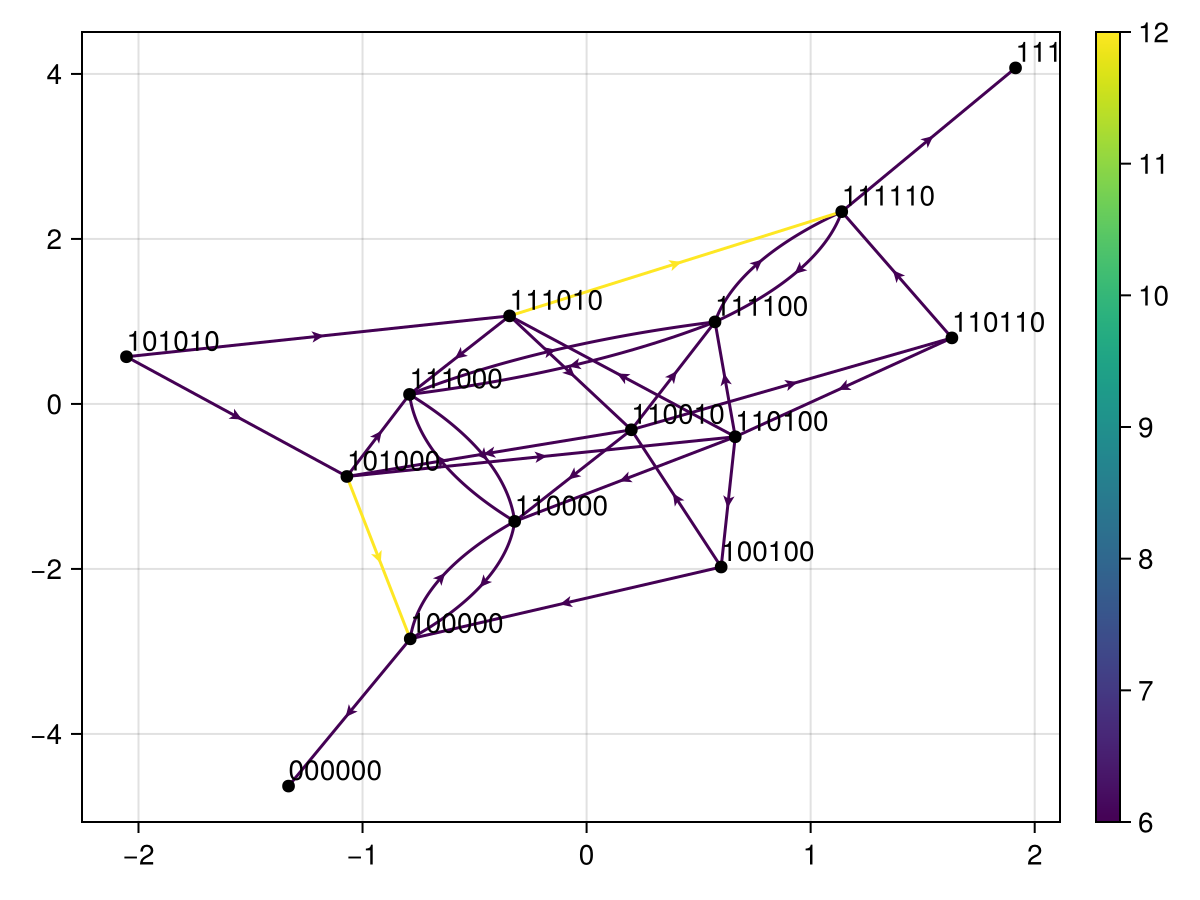

In [269]:
nmg = make_ned_meta_graph(6, 170;
    merge_shifted=true
)
fap = plot_nmg(nmg)

In [270]:
xx = collect(labels(nmg))
display(xx[1:4])
display(nmg[xx[1]])
s, d = collect(edge_labels(nmg))[1]
display(nmg[s, d])
typeof(nmg)

4-element Vector{Vector{Int64}}:
 [0, 0, 0, 0, 0, 0]
 [1, 0, 0, 0, 0, 0]
 [1, 1, 0, 0, 0, 0]
 [1, 0, 1, 0, 0, 0]

"000000"

6.0

MetaGraph{Int64, SimpleDiGraph{Int64}, Vector{Int64}, String, Float64, @NamedTuple{code::Int64, L::Int64, desc::String}, typeof(identity), Float64}

In [284]:
ff = make_full_splitprober(nmg)
p = xx[14]
@show p
ll = ff(p)
# values(ll)

p = [1, 1, 1, 1, 1, 1]


Dict{Vector{Vector{Int64}}, Float64} with 1 entry:
  [[1, 1, 1, 1, 1, 1]] => 1.0

# Bits and bobs

In [38]:
Ks_to_cacode([1 1; 1 1], [0 0; 0 0])

255

K01 = [1 1; 0 0]
K10 = [1 0; 0 0]


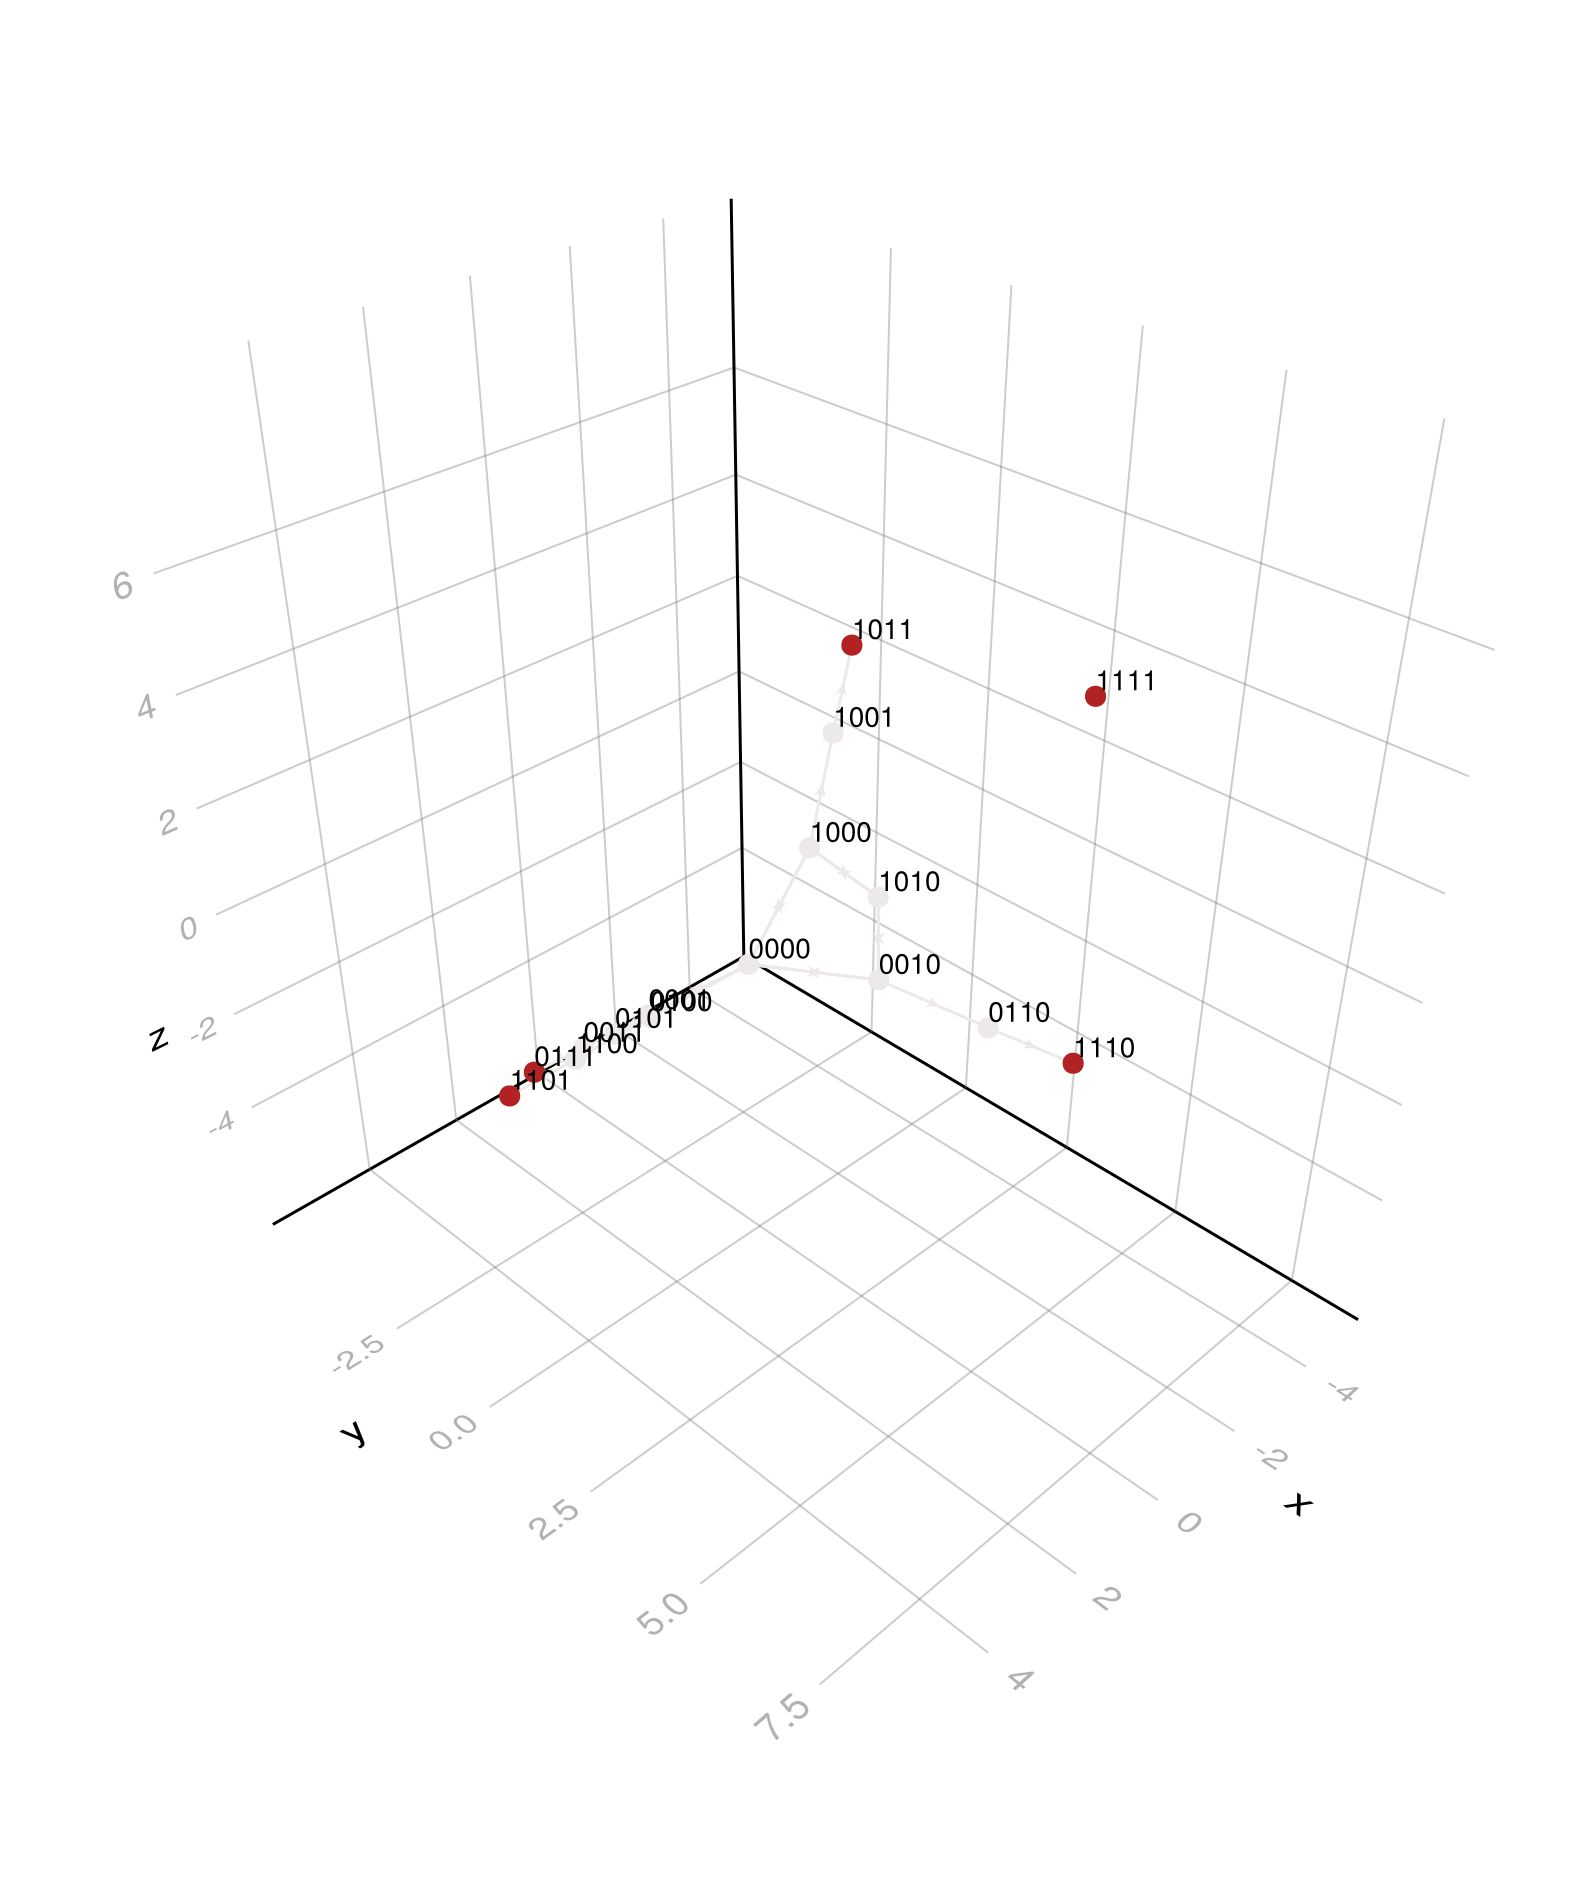

In [743]:
ned = make_ca_ned(L, 203)
faa = plotgm(ned;
    layout=Spring(dim=3),
    get_ac_coloring_kwargs(ned)...
)
display(GLMakie.Screen(), faa.figure)
faa.figure

In [40]:
@time xx = find_singlestateac_rules.(3:14);

 51.245697 seconds (85.55 M allocations: 14.346 GiB, 1.40% gc time)


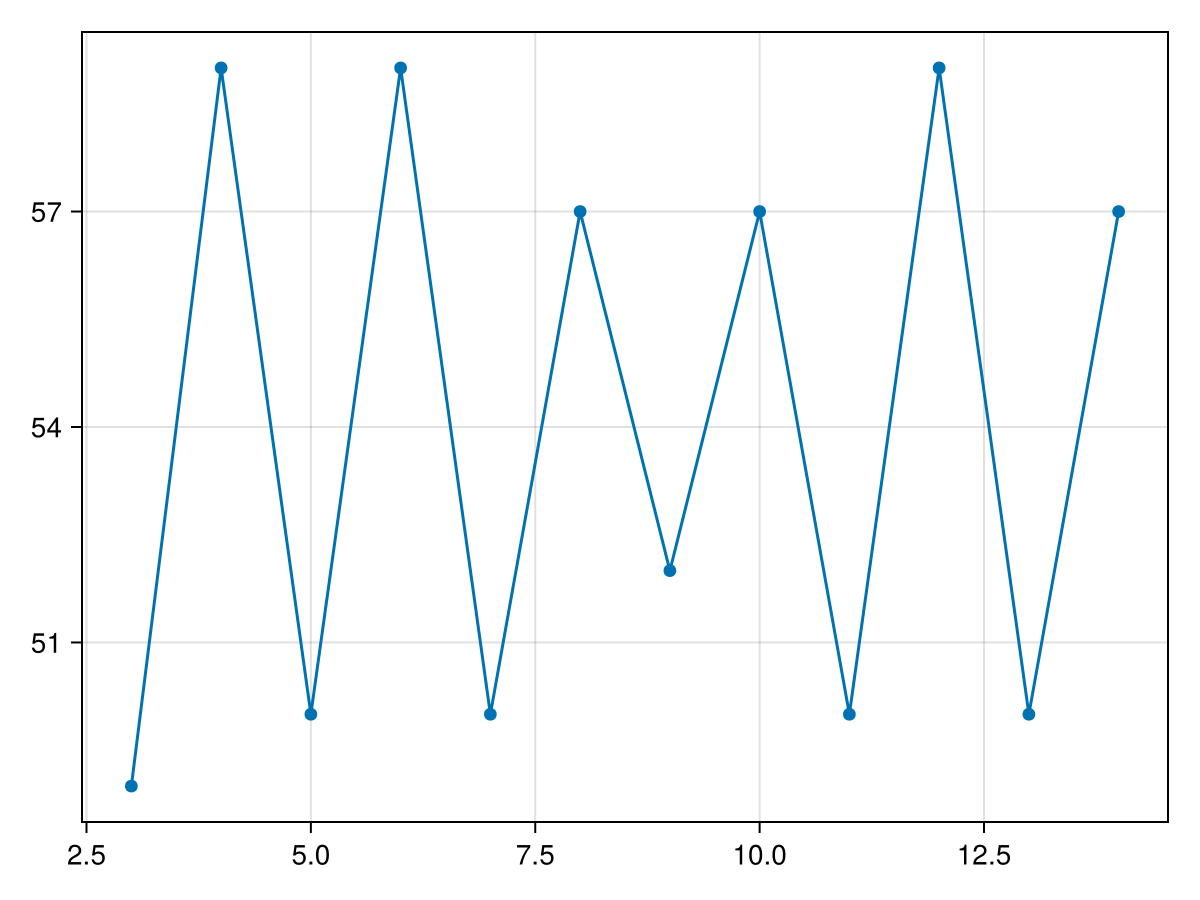

In [41]:
scatterlines(3:14, length.(xx))

In [2]:
GC.gc()
empty!(Out)
GC.gc()